In [1]:
import re
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import dataframe
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col

In [2]:
def quantify_nans(spark_df: dataframe.DataFrame, plot=True):
    # Quantifying null values
    # how many rows does the dataframe have?
    mili_rows=spark_df.count()

    mili_nan = spark_df.select([
        count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_df.columns
    ]).toPandas()

    mili_percentages_nan = mili_nan*100/mili_rows
    print(mili_percentages_nan)
    print('{} is the percentage of nan values in {}'.format([ele for ele in mili_percentages_nan.values.tolist()], spark_df.columns))
    
    if plot:
        sns.barplot(data=mili_percentages_nan, palette='RdBu',orient='h')

In [3]:
# craete a spark session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# load filtered articles (parquet)
conflict_articles = spark.read.parquet("../../data/data_processed/union_3_cat.parquet/")
conflict_articles.count()

17468

In [4]:
conflict_articles.printSchema()

root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- article_lenght: integer (nullable = true)
 |-- views: long (nullable = true)
 |-- refs_count: long (nullable = true)
 |-- link_count: long (nullable = true)
 |-- death: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- location: string (nullable = true)



In [5]:
conflict_articles.head(4)

[Row(id=50429564, title='2016 Samawa bombing', categories='civilian attack', article_lenght=2488, views=9998, refs_count=2, link_count=26, death='33+ (+2)', end_date='1 May 2016', location='Samawah (Q750679)'),
 Row(id=39900222, title='Harok family murder', categories='civilian attack', article_lenght=35907, views=53091, refs_count=49, link_count=52, death='4', end_date='22 May 2013', location='Zatloukalova 404/49a, [[Brno]]-Ivanovice, [[Czech Republic]]'),
 Row(id=46935886, title='1993 Aurora shooting', categories='civilian attack, criminal ', article_lenght=10075, views=271842, refs_count=11, link_count=52, death='4', end_date='December 14, 1993', location='12293 East Iliff Avenue,<br/>[[Aurora, Colorado]], U.S.'),
 Row(id=38247068, title='In Amenas hostage crisis', categories='civilian attack', article_lenght=55589, views=99062, refs_count=106, link_count=128, death='At least 67 (at least 37 foreign hostages, an Algerian security guard and 29 terrorists)', end_date=None, location='W

    location   end_date      death
0  11.088848  12.411266  34.331349
[[11.08884817952828, 12.411266315548431, 34.33134875200366]] is the percentage of nan values in ['location', 'end_date', 'death']


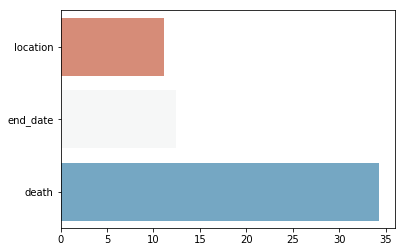

In [6]:
quantify_nans(conflict_articles.select(['location', 'end_date', 'death']))

In [7]:
df_articles = conflict_articles.toPandas().set_index('id')

In [8]:
df_articles.head(4)

,title,categories,article_lenght,views,refs_count,link_count,death,end_date,location
id,,,,,,,,,
50429564,2016 Samawa bombing,civilian attack,2488,9998,2,26,33+ (+2),1 May 2016,Samawah (Q750679)
39900222,Harok family murder,civilian attack,35907,53091,49,52,4,22 May 2013,"Zatloukalova 404/49a, [[Brno]]-Ivanovice, [[Cz..."
46935886,1993 Aurora shooting,"civilian attack, criminal",10075,271842,11,52,4,"December 14, 1993","12293 East Iliff Avenue,<br/>[[Aurora, Colorad..."
38247068,In Amenas hostage crisis,civilian attack,55589,99062,106,128,"At least 67 (at least 37 foreign hostages, an ...",None,"West of [[In Amenas]], Algeria"


In [9]:
orignal_data_split = [(idx, foo) for (idx, ele) in
                      zip(df_articles.location.index.values.tolist(), df_articles.location.str.split(',')) \
                      if ele 
                      for foo in ele]

In [10]:
orignal_data_split[-40:]

[(3391853, ' Veracruz (Q6154758)'),
 (38574359, 'Limestone County (Q501108)'),
 (32039986, 'Transjordan (Q1121819)'),
 (30290197, 'Huon Peninsula (Q1350254)'),
 (27358822, 'Border region of [[Hubei]] – [[Henan]] – [[Anhui]] provinces'),
 (27358822, ' China'),
 (6304854, 'Chachapoyas (Q757133)'),
 (39150941, 'Strait of Dover (Q159898)'),
 (53564213, 'Jinan (Q170247)'),
 (157099, 'Fleurus (Q314922)'),
 (30403205, 'Spinkai (Q7577573)'),
 (25249737, 'near [[Pizzighettone]]'),
 (25249737, ' then in the [[Duchy of Milan]]'),
 (25249737, ' present-day [[Italy]]'),
 (26598683, 'Apra Harbor (Q621760)'),
 (29669331, 'off [[Lombok Strait]]'),
 (29669331, ' [[Java Sea]]'),
 (29669331, ' [[Southeast Asia]]'),
 (48487289, 'Kiev (Q1899)'),
 (251234, 'Near [[Brownsville'),
 (251234, ' Texas|Brownsville]]'),
 (251234, ' Texas'),
 (23182397, '[[Chalai'),
 (23182397, ' Sri Lanka|Chalai]]'),
 (23182397, ' North of Mullaitivu'),
 (1807917, 'Spicheren (Q22756)'),
 (34627932, 'Ceber'),
 (34627932, ' Świętokr

In [11]:
re_spaced_words = re.compile('\w+-*\s*', flags=re.IGNORECASE)

In [12]:
cleaned = [(idx, ' '.join(re_spaced_words.findall(ele))) for (idx, ele) in orignal_data_split]

cleaned[-40:]

[(3391853, 'Veracruz  Q6154758'),
 (38574359, 'Limestone  County  Q501108'),
 (32039986, 'Transjordan  Q1121819'),
 (30290197, 'Huon  Peninsula  Q1350254'),
 (27358822, 'Border  region  of  Hubei Henan Anhui provinces'),
 (27358822, 'China'),
 (6304854, 'Chachapoyas  Q757133'),
 (39150941, 'Strait  of  Dover  Q159898'),
 (53564213, 'Jinan  Q170247'),
 (157099, 'Fleurus  Q314922'),
 (30403205, 'Spinkai  Q7577573'),
 (25249737, 'near  Pizzighettone'),
 (25249737, 'then  in  the  Duchy  of  Milan'),
 (25249737, 'present- day  Italy'),
 (26598683, 'Apra  Harbor  Q621760'),
 (29669331, 'off  Lombok  Strait'),
 (29669331, 'Java  Sea'),
 (29669331, 'Southeast  Asia'),
 (48487289, 'Kiev  Q1899'),
 (251234, 'Near  Brownsville'),
 (251234, 'Texas Brownsville'),
 (251234, 'Texas'),
 (23182397, 'Chalai'),
 (23182397, 'Sri  Lanka Chalai'),
 (23182397, 'North  of  Mullaitivu'),
 (1807917, 'Spicheren  Q22756'),
 (34627932, 'Ceber'),
 (34627932, 'Świętokrzyskie  Voivodeship  Q1878926'),
 (23309899, 'E

In [13]:
# create a series with the idx of the original data with location splitted by comma
location = pd.DataFrame([tup[1] for tup in cleaned], 
                        index=[tup[0] for tup in cleaned], 
                        columns=['locations'])

location.head(40)

,locations
50429564,Samawah Q750679
39900222,Zatloukalova 404 49a
39900222,Brno Ivanovice
39900222,Czech Republic
46935886,12293 East Iliff Avenue
46935886,br Aurora
46935886,Colorado
46935886,U S
38247068,West of In Amenas
38247068,Algeria


In [14]:
location = location.groupby(location.index)['locations'].apply(lambda x: "%s" % '|'.join(x))

In [15]:
location.head()

771     Eastern  North  America|Caribbean  Sea|Indian ...
863     Southern  United  States  Q49042|Northern  Uni...
3793    Ambion  Hill  Q4741491|Battle  of  Bosworth  F...
4005                                     Farsala  Q985596
4049                                   Blindheim  Q514914
Name: locations, dtype: object

In [16]:
df_articles.join(location).to_csv('../../data/data_processed/CleanLocation_union_3_cat')

In [17]:
test = pd.read_csv('../../data/data_processed/CleanLocation_union_3_cat')
test

,Unnamed: 0,title,categories,article_lenght,views,refs_count,link_count,death,end_date,location,locations
0,771,American Revolutionary War,military conflict,238972,8794983,598,924,"'''United States:'''<br />\n<small>25,000–70,0...",+1783-09-03T00:00:00Z,"Eastern North America, [[Caribbean Sea]], [[In...",Eastern North America|Caribbean Sea|Indian ...
1,863,American Civil War,military conflict,203619,17696187,212,776,"{{plainlist|\n*110,000+ killed in action/died ...",+1865-05-10T00:00:00Z,"[Southern United States (Q49042), Northern Uni...",Southern United States Q49042|Northern Uni...
2,3793,Battle of Bosworth Field,military conflict,97380,1107588,34,305,unknown,22 August 1485,"[Ambion Hill (Q4741491), Battle of Bosworth (F...",Ambion Hill Q4741491|Battle of Bosworth F...
3,4005,Battle of Pharsalus,military conflict,22469,601822,20,99,~230 (according to Caesar),9 August 48 BC,Farsala (Q985596),Farsala Q985596
4,4049,Battle of Blenheim,military conflict,66889,458284,95,201,"'''12,484'''<br />4,542 killed<br />7,942 wounded",13 August 1704,Blindheim (Q514914),Blindheim Q514914
5,4050,Battle of Ramillies,military conflict,55678,121772,87,191,"1,066 killed<br>2,597 wounded",23 May 1706,Ramillies (Q531456),Ramillies Q531456
6,4160,Battle of Lostwithiel,military conflict,5670,21225,0,44,NaN,+1644-09-02T00:00:00Z,Lostwithiel (Q723517),Lostwithiel Q723517
7,4283,Battle of Peleliu,military conflict,45153,1016649,28,228,"2,336 killed<br>8,450 wounded",+1944-11-25T00:00:00Z,Peleliu (Q497981),Peleliu Q497981
8,4284,Battle of Stalingrad,military conflict,127960,5955534,137,436,"{{Unbulleted list\n|'''647,300–868,374'''\n|Fl...",+1943-02-02T00:00:00Z,Volgograd (Q914),Volgograd Q914
9,4356,Battle of Waterloo,military conflict,159734,4975037,19,370,"'''Total''': 41,000\n* 24,000 to 26,000 casual...",18 June 1815,Waterloo (Q179034),Waterloo Q179034
